# Predicting MPG with SDC

**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Utilize characteristics from various cars to predict miles-per-gallon fuel consumption.  The prediction equation is determined using Stocastic Gradient Descent minimization method.

In [1741]:
# CONSTANTS
DATASET_FILE = 'autompg_dataset.csv'
NUMBER_FOR_TRAINING = 200
NUMBER_FOR_VALIDATION = 100
OUTPUT_FEATURE='mpg'
INPUT_FEATURES=['horsepower', 'weight']
EPOCHS = 1000

In [1742]:
# LIBRARIES
import numpy as np                  # matrix manipulation
import random                       # shuffle data
import matplotlib.pyplot as plt     # surface plot

In [1743]:
# FUNCTIONS
# Create Augmented Design Matrix
def AugmentedDesignMatrix(dataSet, features):
    # Create the design matrix.
    adm = dataSet[features[0]]
    for feature in features[1:]:
        adm = np.column_stack((adm,dataSet[feature]))
     # Augment the design matrix to accomodate the bias term.
    adm = np.column_stack((adm,np.ones(len(adm))))
    return adm

In [1744]:
# Calculate Mean Squared Error
def MSE(actual, predicted):
    return np.square(np.subtract(actual, predicted)).mean()

In [1745]:
def PredictionEquation(y, xs, w):
    eq = '{} = '.format(y)
    wfmat = lambda i: ('+' if i > 0 else '') + '{:0.6}'.format(i)
    for idx, x in enumerate(xs):
        eq = eq + '{}*{}'.format(wfmat(w[idx]), x)
    eq = eq + wfmat(w[-1])
    return eq

In [1746]:
def StochasticGradientDecent(trainSet, valSet, outParam, inParam, epochs=100,batchSize=1,etaMax=0.1, beta=1):
    trainMse = []
    Ytrain = trainSet[outParam]
    Xtrain = AugmentedDesignMatrix(dataSet=trainSet,features=inParam)

    valMse = []
    Yval = valSet[outParam]
    Xval = AugmentedDesignMatrix(dataSet=valSet,features=inParam)

    Wa = np.zeros(len(inParam)+1)
    itters = round(len(trainSet)/batchSize)

    for e in range(epochs):
        for i in range(itters):
            batch = dataSet[batchSize*i:batchSize*(i+1)]
            Ybatch = batch[outParam]
            Xbatch = AugmentedDesignMatrix(dataSet=batch,features=inParam)
            eta = etaMax / (1 + (beta * i))
            Wa = Wa - eta * (2/batchSize) * Xbatch.T.dot(Xbatch.dot(Wa)-Ybatch)

        trainMse.append(MSE(Ytrain,Xtrain.dot(Wa)))
        valMse.append(MSE(Yval,Xval.dot(Wa)))

    return Wa, trainMse, valMse

In [1747]:
# Load data file
csvFile = open(DATASET_FILE, 'r')
dataSet = np.genfromtxt(csvFile, delimiter=',', names=True, case_sensitive=True)
csvFile.close()

In [1748]:
# shuffle data randomly so that training will not use same sets every time.
#random.shuffle(dataSet)

In [1749]:
# Split the data set into groups for training, validation and test.
trainData = dataSet[:NUMBER_FOR_TRAINING]
valData = dataSet[NUMBER_FOR_TRAINING+1:NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION]
testData = dataSet[NUMBER_FOR_TRAINING+NUMBER_FOR_VALIDATION+1:]

## Part (a): Batch Size 1
tbd

In [1750]:
Wa, trainMse, valMse = StochasticGradientDecent(trainSet=trainData, valSet=valData, outParam=OUTPUT_FEATURE, inParam=INPUT_FEATURES, epochs=1000,batchSize=1,etaMax=1.0E-7, beta=0.1)

In [1751]:
print(PredictionEquation(y=OUTPUT_FEATURE, xs=INPUT_FEATURES, w=Wa))

mpg = -0.0137028*horsepower+0.00715047*weight+0.0919156


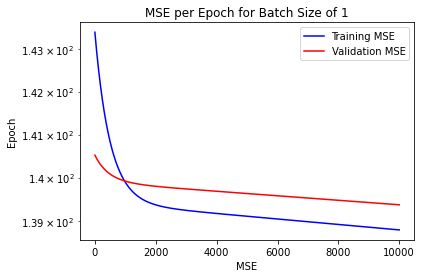

In [1752]:
plt.plot(trainMse,color='b',label='Training MSE')
plt.plot(valMse,color='r',label='Validation MSE')
plt.yscale('log')
plt.xlabel('MSE')
plt.ylabel('Epoch')
plt.legend()
plt.title('MSE per Epoch for Batch Size of 1')
plt.show()